# Autoencoder for Recommendation Systems
---

In [64]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
ratings = pd.read_csv('../data/recommendation_system/movie_lens/ratings.dat',
                 sep='::',
                 engine='python',
                 encoding='latin-1',
                 names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pd.read_csv('../data/recommendation_system/movie_lens/movies.dat',
                    sep='::',
                    engine='python',
                    encoding='latin-1',
                    names=['movieid', 'title', 'genre']).set_index("movieid")

In [68]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [69]:
movies.head()

,title,genre
movieid,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [70]:
rating_counts = ratings.groupby("movieid")["rating"].count().sort_values(ascending=False)

# only the 500 most popular movies
pop_ratings = ratings[ratings["movieid"].isin((rating_counts).index[0:500])]
pop_ratings = pop_ratings.set_index(["movieid", "userid"])

In [71]:
pop_ratings.head()

,,rating,timestamp
movieid,userid,,
185,1,5.0,838983525
231,1,5.0,838983392
292,1,5.0,838983421
316,1,5.0,838983392
329,1,5.0,838983392


In [72]:
prefs = pop_ratings["rating"]

mean_0 = pop_ratings["rating"].mean()
prefs = prefs - mean_0

mean_i = prefs.groupby("movieid").mean()
prefs = prefs - mean_i

mean_u = prefs.groupby("userid").mean()
prefs = prefs - mean_u


pref_matrix = prefs.reset_index()[["userid", "movieid", "rating"]].pivot(index="userid", columns="movieid", values="rating")

In [73]:
pref_matrix.head()

movieid,1,2,3,5,6,7,10,11,16,17,...,7361,7438,8360,8368,8636,8665,8961,32587,33493,33794
userid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-2.778443,NaN,NaN,NaN,NaN,-0.214692,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
pref_matrix.fillna(0, inplace=True)

In [75]:
def sparsity_calculation(data):
    data = np.nan_to_num(data)
    return round(1. - np.count_nonzero(data) / data.size, 3) * 100

In [76]:
sparsity_calculation(pref_matrix)

85.6

In [77]:
model = tf.keras.Sequential([
    #encoder
    tf.keras.layers.Dense(units=256, activation='tanh', name='enc_1', input_dim=pref_matrix.shape[1]),
    tf.keras.layers.BatchNormalization(name='batch_1'),
    tf.keras.layers.Dense(units=128, activation='tanh', name='enc_2'),
    tf.keras.layers.BatchNormalization(name='batch_2'),
    tf.keras.layers.Dropout(0.5, name='drop_2'),

    #bottleneck
    tf.keras.layers.Dense(units=32, activation='linear', name='embeddings'),

    #decoder
    tf.keras.layers.Dense(units=128, activation='tanh', name='dec_1'),
    tf.keras.layers.Dense(units=pref_matrix.shape[1], activation='linear', name='user_rating_pred')
])

In [78]:
model.compile(optimizer='adam', loss='mse')

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', verbose=1)

In [80]:
history = model.fit(
    pref_matrix,
    pref_matrix,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[callback]
)

Epoch 1/50
1962/1962 [==============================] - 10s 4ms/step - loss: 0.0943 - val_loss: 0.0892
Epoch 2/50
1962/1962 [==============================] - 5s 3ms/step - loss: 0.0878 - val_loss: 0.0874
Epoch 3/50
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0868 - val_loss: 0.0866
Epoch 4/50
1962/1962 [==============================] - 5s 3ms/step - loss: 0.0864 - val_loss: 0.0866
Epoch 5/50
1962/1962 [==============================] - 7s 3ms/step - loss: 0.0861 - val_loss: 0.0910
Epoch 6/50
1962/1962 [==============================] - 5s 3ms/step - loss: 0.0859 - val_loss: 0.0900
Epoch 7/50
1962/1962 [==============================] - 5s 2ms/step - loss: 0.0858 - val_loss: 0.0902
Epoch 8/50
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0858 - val_loss: 0.0886
Epoch 9/50
1962/1962 [==============================] - 10s 5ms/step - loss: 0.0858 - val_loss: 0.0908
Epoch 00009: early stopping


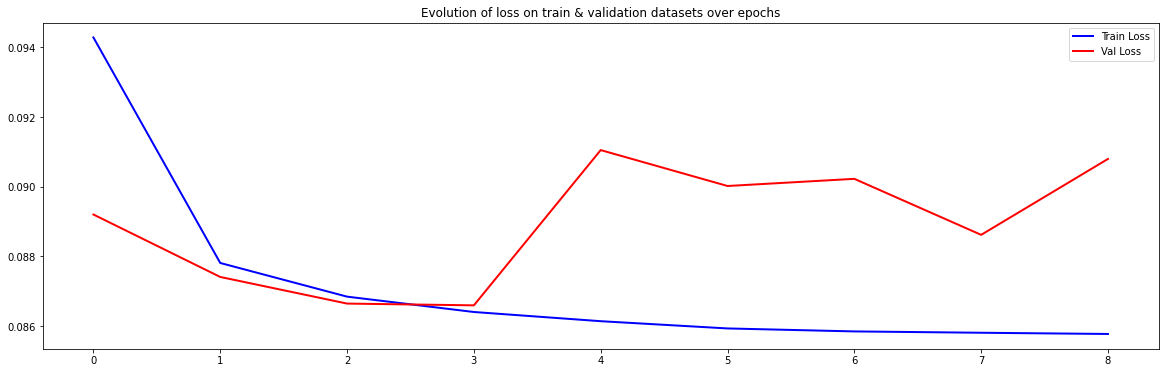

In [81]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.plot(epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

In [82]:
predictions = model.predict(pref_matrix)

In [83]:
predictions = pd.DataFrame(predictions, columns=pref_matrix.columns, index=pref_matrix.index)

In [84]:
predictions.head()

movieid,1,2,3,5,6,7,10,11,16,17,...,7361,7438,8360,8368,8636,8665,8961,32587,33493,33794
userid,,,,,,,,,,,,,,,,,,,,,
1,-0.148986,0.059091,0.052215,0.082359,-0.093471,0.066327,0.008126,0.083269,-0.038406,-0.001630,...,0.057987,0.008920,0.021349,0.020996,-0.035740,0.012593,-0.030025,-0.035415,-0.002439,-0.044405
2,-0.117652,0.050064,0.020528,0.037800,-0.135646,0.039065,-0.119224,0.086228,-0.090979,0.012690,...,0.045863,0.020351,-0.011435,-0.010230,-0.072625,-0.023421,-0.038389,-0.006881,-0.011360,-0.080915
3,-0.142661,0.047826,0.032043,0.068232,-0.070372,0.067541,-0.014205,0.091553,-0.038560,0.032043,...,0.050052,0.003268,0.028991,-0.001594,-0.067870,0.008130,-0.031149,-0.011111,-0.017887,-0.045234
4,0.163957,0.177020,0.051946,0.108267,-0.133305,0.077169,0.059411,0.136923,-0.027169,0.065966,...,-0.007248,0.002035,0.010718,-0.007156,-0.053186,-0.015260,-0.027799,0.002520,0.005192,-0.020249
5,-1.628515,-0.081278,-0.013174,0.001828,0.083406,0.055628,0.019659,0.005920,0.024148,0.196646,...,0.076155,0.021406,-0.077173,-0.001023,-0.118192,0.010257,-0.142166,0.031449,-0.006560,-0.078074


In [85]:
def recommend_for_user(real_user_item_matrix, pred_user_item_matrix, content_data, user_id, top_n):

  ratings_df = real_user_item_matrix.loc[user_idx].to_frame('ratings').join(pred_user_item_matrix.loc[user_idx].to_frame('pred_ratings'))
  recs_df = ratings_df[ratings_df['ratings'] == 0].sort_values(by='pred_ratings', ascending=False).drop('ratings', axis=1)
  watch_df = ratings_df[ratings_df['ratings'] != 0].sort_values(by='ratings', ascending=False).drop('pred_ratings', axis=1)

  recs_df = recs_df.join(content_data).head(top_n)
  watch_df = watch_df.join(content_data).head(top_n)

  return recs_df, watch_df

In [86]:
user_idx = 4
top_n = 20

recs_df, watch_df = recommend_for_user(real_user_item_matrix=pref_matrix, pred_user_item_matrix=predictions, content_data=movies, user_id=user_idx, top_n=top_n)

In [87]:
print('RECOMMENDATIONS:')
display(recs_df)
print('=' * 100)
print('WATCH LIST:')
display(watch_df)

RECOMMENDATIONS:


,pred_ratings,title,genre
movieid,,,
2858,0.537632,American Beauty (1999),Drama
780,0.457443,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|War
736,0.344752,Twister (1996),Action|Adventure|Romance|Thriller
539,0.256311,Sleepless in Seattle (1993),Comedy|Drama|Romance
48,0.202016,Pocahontas (1995),Animation|Children|Musical|Romance
141,0.191502,"Birdcage, The (1996)",Comedy
2,0.177020,Jumanji (1995),Adventure|Children|Fantasy
1356,0.173531,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
1917,0.173492,Armageddon (1998),Action|Romance|Sci-Fi|Thriller


WATCH LIST:


,ratings,title,genre
movieid,,,
153,1.443146,Batman Forever (1995),Action|Adventure|Comedy|Crime
410,1.383039,Addams Family Values (1993),Comedy
586,1.301728,Home Alone (1990),Children|Comedy
317,1.203500,"Santa Clause, The (1994)",Comedy|Drama|Fantasy
329,1.023024,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
316,1.009942,Stargate (1994),Action|Adventure|Sci-Fi
592,0.972738,Batman (1989),Action|Crime|Sci-Fi|Thriller
500,0.950192,Mrs. Doubtfire (1993),Comedy|Drama
587,0.906725,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
